In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
CURRENT_DIR = Path('.').resolve()
MODULES_DIR = CURRENT_DIR.parent.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('Data','Process')

----

# Image augmentation

Image augmentation is an importatn technique in image classification projects. Image augmentation is the creation of additional training data by marking minor alterations to images in certian ways in order to create new images. For example, we can do the following:

- Imagen rotation
- Image translation
- Horizontal flip
- Zooming into the image

The motivation for image augmentation is that CNNs require a huge amount of training data before they can generalize well. However, it is often difficult to collect data, more so for images. With augmentation, we can artificially create new training data based on the existing images.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

In [8]:
list_dogs = []

for archivo in DATA_DIR.joinpath('Train','Dog').rglob('*'):
    if archivo.is_file():
        list_dogs.append(archivo)

In [49]:
all_images = []

random_img = random.choice(list_dogs)
random_img = plt.imread(str(random_img))
all_images.append(random_img)

In [50]:
random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

In [51]:
for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

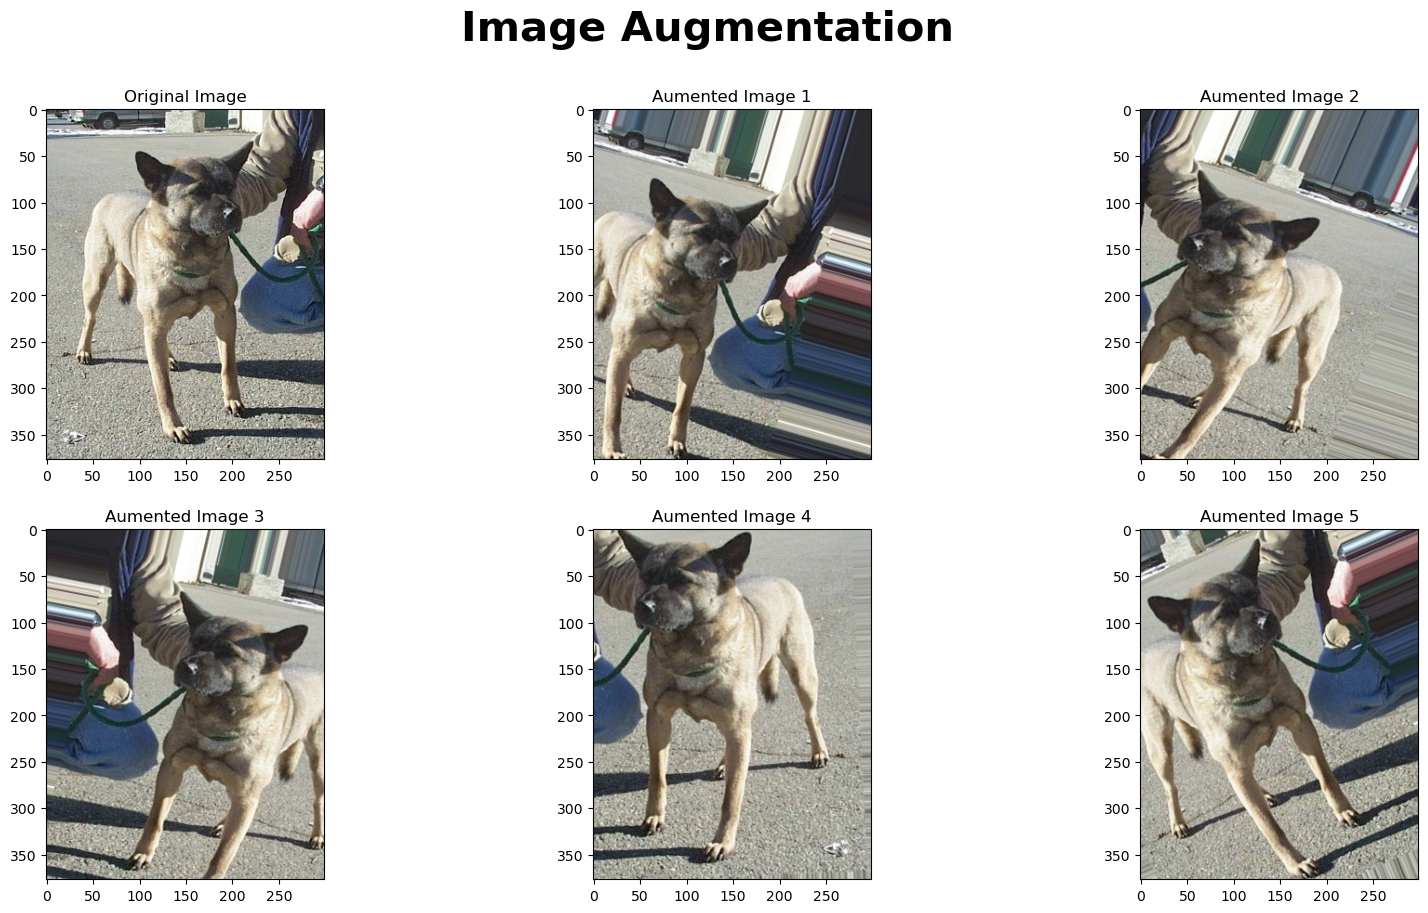

In [55]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

for ax, i in zip(axs.flat, range(6)):
    ax.imshow(all_images[i])
    if i == 0:
        ax.set_title('Original Image')
    else:
        ax.set_title(f'Aumented Image {i}')
fig.suptitle('Image Augmentation',fontsize=30, weight='bold')

plt.show()

-----

# Model Building

We'll take two different approaches to model building. First, we'll start by building a relative simple CNN cosisting of few layers. We'll take a look at the performance of the simple model, and discuss it pros and cons. Next' we'll use a model VGG16 model. We'll see how we can leverage on the pre-trained weights to adapt the VGG16 model for cats vers dogs image classification

## Building simple CNN

We're going to build a basic CNN cosisting of this repeating pattern, as shown in the following diagram:

![pattern](https://i.imgur.com/Xq4ZmSr.png)

This basic CNN consists of two repeated blocks of **Convolution** and **Max Pooling**, following by **Fully Connected**.

![alternative](https://i.imgur.com/tqqF9j2.png)

We'll start off by declaring a new `Sequential` model instance:

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

Before we add any convolutional layers, it is useful to think about the hyperparameters that we are going to use.

- **Convolutional layer filter size**: Most modern CNNs use small filter size of 3 x 3
- **Number of filters**: Let's use a filter number of 32. 
- **Input size**: Let's use an input size of 32 x 32 pixels
- **Max pooling size**: A common max pooling size is 2x2. This will halve the input layer dimensions
- **Batch size**: Let's use a batch size of 16
- **Steps por epoch**: This is the number of iterations in each traning epoch. Typically, this is equal to the number of training samples divided by the batch size
- **Epochs**: The number of epochs to train our data. Let's train our model for 10 epochs.

Let's declare variable for these hyperparameters so that they are constant throughout our code:

In [58]:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000/BATCH_SIZE
EPOCHS = 10

We can now add the firts convolutional layer, with 32 filters, each of size (3x3)

In [59]:
model.add(Conv2D(NUM_FILTERS,(FILTER_SIZE,FILTER_SIZE),
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                 activation='relu'))

We add a max pooling layer

In [60]:
model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

This is the basic convolution-pooling pattern of our CNN. Let's repeat this once more according to our modell architecture:

In [61]:
model.add(Conv2D(NUM_FILTERS,(FILTER_SIZE,FILTER_SIZE),
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

We are now done with the convolution and pooling layers. We need to flatten its input. `Flatten` is a function in Keras

In [62]:
model.add(Flatten())

We can now add a fully connected layer with 128 nodes

In [63]:
model.add(Dense(units=128, activation='relu'))

We add a dropout layer. The dropout layer randomly sets a certain fraction of its input to 0. This helps to reduce overfitting, by ensurign that the model does not place too much emphasis on certain wrights:


In [64]:
model.add(Dropout(0.5))

We add one last fully connected layer to our model

In [65]:
model.add(Dense(units=1, activation= 'sigmoid'))

We'll compile our model using the adam optimeizer. The loss function is `binary_crossentropy`

In [66]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

-----

# Training 

We're now ready to train our CNN. Notice that we have not loaded any of the data into memory. We'll use the `ImageDataGenerator` and `flow_from_directory` to train our model in real time, which loads batches of the dateset into memory only as requiered:

In [73]:
training_data_generator = ImageDataGenerator(rescale= 1./255)

training_set = training_data_generator.flow_from_directory(str(DATA_DIR.joinpath('Train')),
                                                           target_size=(INPUT_SIZE, INPUT_SIZE),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='binary')

Found 19996 images belonging to 2 classes.


In [74]:
model.fit_generator(training_set,steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1)

/tmp/ipykernel_36745/2455287318.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(training_set,steps_per_epoch=STEPS_PER_EPOCH,


Epoch 1/10


2023-06-24 15:14:34.479437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 155s 123ms/step - loss: 0.6452 - accuracy: 0.6173
Epoch 2/10
1250/1250 [==============================] - 177s 142ms/step - loss: 0.5550 - accuracy: 0.7150
Epoch 3/10
1250/1250 [==============================] - 156s 125ms/step - loss: 0.5026 - accuracy: 0.7588
Epoch 4/10
1250/1250 [==============================] - 150s 120ms/step - loss: 0.4663 - accuracy: 0.7772
Epoch 5/10
1250/1250 [==============================] - 143s 114ms/step - loss: 0.4437 - accuracy: 0.7908
Epoch 6/10
1250/1250 [==============================] - 156s 125ms/step - loss: 0.4177 - accuracy: 0.8069
Epoch 7/10
1250/1250 [==============================] - 154s 123ms/step - loss: 0.3952 - accuracy: 0.8200
Epoch 8/10
1250/1250 [==============================] - 152s 122ms/step - loss: 0.3717 - accuracy: 0.8297
Epoch 9/10
1250/1250 [==============================] - 157s 126ms/step - loss: 0.3519 - accuracy: 0.8431
Epoch 10/10
1250/1250 [==============================] - 

## Testing

In [76]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

In [77]:
test_set = testing_data_generator.flow_from_directory(
    str(DATA_DIR.joinpath('Test')),
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [80]:
score = model.evaluate_generator(
    test_set,
    steps=len(test_set)
)

for idx, metric in enumerate(model.metrics_names):
    print(f"{metric}: {score[idx]: .2f}")

/tmp/ipykernel_36745/1448043401.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(
2023-06-24 15:49:37.292857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


loss:  0.45
accuracy:  0.80


Save our model

In [75]:
model.save_weights('first_try.h5')